# CompressAI inference demo

In [1]:
import math
import torch
from torchvision import transforms

from PIL import Image

import matplotlib.pyplot as plt

In [2]:
from pytorch_msssim import ms_ssim

In [3]:
from compressai.zoo import bmshj2018_factorized

In [4]:
from ipywidgets import interact, widgets

## Global settings

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Load a pretrained model

In [6]:
net = bmshj2018_factorized(quality=4, pretrained=True).eval().to(device)

In [7]:
print(f'Parameters: {sum(p.numel() for p in net.parameters())}')
print(f'Entropy bottleneck(s) parameters: {sum(p.numel() for p in net.aux_parameters())}')

Parameters: 2986435
Entropy bottleneck(s) parameters: 11712


## 1. Inference

### Load image and convert to 4D float tensor

First, we need to load an RGB image and convert it to a 4D floating point tensor, as the network expected an input tensor of size: `(batch_size, 3, height, width)`.

In [8]:
img = Image.open('./assets/stmalo_fracape.png').convert('RGB')
x = transforms.ToTensor()(img).unsqueeze(0)

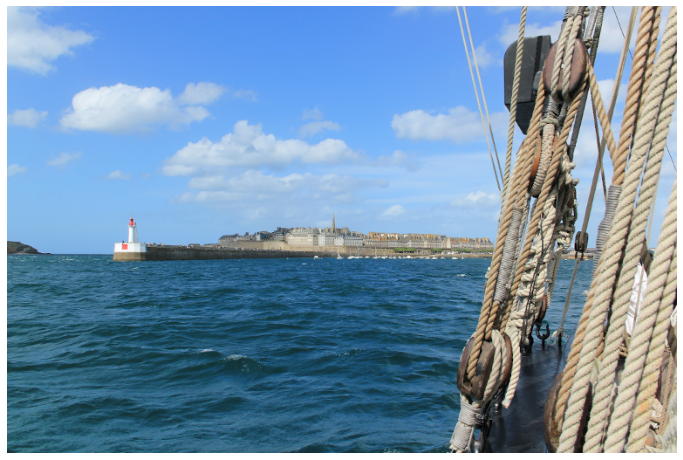

In [33]:
%matplotlib inline
plt.figure(figsize=(12, 9))
plt.axis('off')
plt.imshow(img)
plt.show()

### Run the network

In [34]:
with torch.no_grad():
    out_net = net.forward(x)
print(out_net.keys())

dict_keys(['x_hat', 'likelihoods'])


We obtain a dictionary with the decoded/reconstructed image tensor `x_hat` and the latent likelihoods.

### Visualize result

Convert the Tensor back to a 2D Pillow image:

In [35]:
rec_img = transforms.ToPILImage()(out_net['x_hat'].squeeze())

In [36]:
diff = torch.mean((out_net['x_hat'] - x).abs(), axis=1).squeeze()

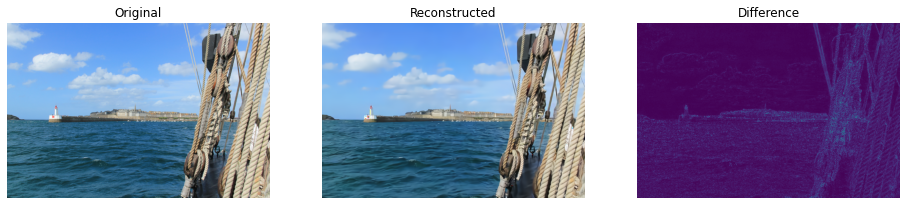

In [37]:
%matplotlib inline
fix, axes = plt.subplots(1, 3, figsize=(16, 12))
for ax in axes:
    ax.axis('off')
    
axes[0].imshow(img)
axes[0].title.set_text('Original')

axes[1].imshow(rec_img)
axes[1].title.set_text('Reconstructed')

axes[2].imshow(diff, cmap='viridis')
axes[2].title.set_text('Difference')

plt.show()

### Compute metrics

Now, let's compute some common metrics...

In [38]:
def compute_psnr(a, b):
    mse = torch.mean((out_net['x_hat'] - x)**2).item()
    return -10 * math.log10(mse)

def compute_msssim(a, b):
    return ms_ssim(a, b, data_range=1.).item()

def compute_bpp(out_net):
    size = out_net['x_hat'].size()
    num_pixels = size[0] * size[2] * size[3]
    return sum(torch.log(likelihoods).sum() / (-math.log(2) * num_pixels)
              for likelihoods in out_net['likelihoods'].values()).item()

In [39]:
print(f'PSNR: {compute_psnr(x, out_net["x_hat"]):.2f}dB')
print(f'MS-SSIM: {compute_msssim(x, out_net["x_hat"]):.4f}')
print(f'Bit-rate: {compute_bpp(out_net):.3f} bpp')

PSNR: 29.85dB
MS-SSIM: 0.9761
Bit-rate: 0.461 bpp


### Per-latent bit-rate results

In [40]:
def detailed_bpp(out):
    size = out['x_hat'].size()
    num_pixels = size[0] * size[2] * size[3]
    for name, values in out_net['likelihoods'].items():
        bpp_val = torch.log(values).sum() / (-math.log(2) * num_pixels)
        print(f'- "{name}" latent bit-rate: {bpp_val:.3f} bpp')
               
detailed_bpp(out_net)

- "y" latent bit-rate: 0.461 bpp


## 2. Latent visualization

In [41]:
with torch.no_grad():
    y = net.g_a(x)
    y_hat, y_likelihoods = net.entropy_bottleneck(y)
    print(y.size(), y_likelihoods.size())

torch.Size([1, 192, 32, 48]) torch.Size([1, 192, 32, 48])


## Per channel bit-rate

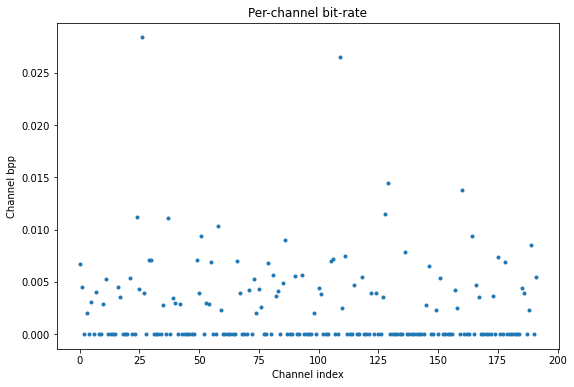

In [42]:
%matplotlib inline
num_pixels = x.size(2) * x.size(3)

channel_bpps = [torch.log(y_likelihoods[0, c]).sum().item() / (-math.log(2) * num_pixels)
                for c in range(y.size(1))]

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(channel_bpps, '.')
ax.title.set_text('Per-channel bit-rate')
ax.set_xlabel('Channel index')
ax.set_ylabel('Channel bpp')
plt.show()

### Order channels by bit-rates

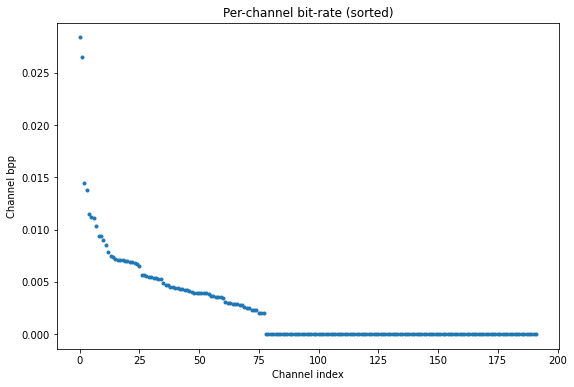

In [43]:
%matplotlib inline
num_pixels = x.size(2) * x.size(3)

ordered_idxs = torch.argsort(torch.Tensor(channel_bpps), descending=True)
ordered_channel_bpps = torch.Tensor(channel_bpps)[ordered_idxs]

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(ordered_channel_bpps, '.')
ax.title.set_text('Per-channel bit-rate (sorted)')
ax.set_xlabel('Channel index')
ax.set_ylabel('Channel bpp')
plt.show()

### Interactive per-channel visualization

<IPython.core.display.Javascript object>


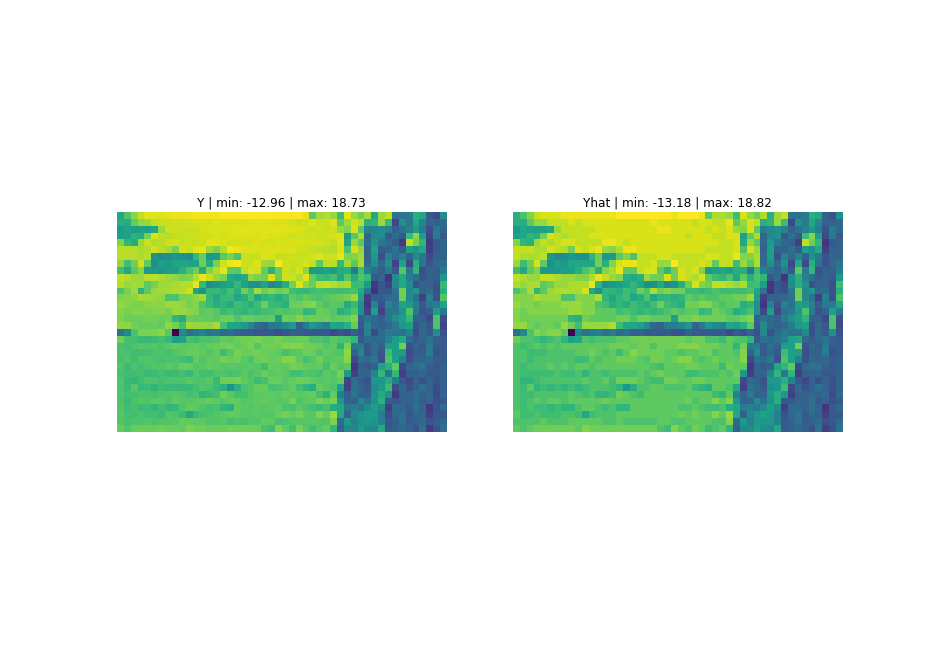

interactive(children=(IntSlider(value=0, continuous_update=False, description='c', max=191), Output()), _dom_c…

<function __main__.show_channel(c)>

In [24]:
%matplotlib notebook

fig, axes = plt.subplots(1, 2, figsize=(13, 9))
for ax in axes:
    ax.axis('off')

def show_channel(c):
    channel = y[0, ordered_idxs[c]]
    axes[0].imshow(channel)
    axes[0].title.set_text(f'Y | min: {channel.min():.2f} | max: {channel.max():.2f}')
    
    channel = y_hat[0, ordered_idxs[c]]
    axes[1].imshow(channel)
    axes[1].title.set_text(f'Yhat | min: {channel.min():.2f} | max: {channel.max():.2f}')

plt.show()
interact(show_channel, c=widgets.IntSlider(min=0, max=y.size(1)-1, step=1,continuous_update=False))

## Quantized vs continuous latent

In [44]:
with torch.no_grad():
    x_hat_y = net.g_s(y)
    x_hat_y_hat = net.g_s(y_hat)

In [45]:
print('Decoded continuous latent:')
print(f'PSNR: {compute_psnr(x, x_hat_y):.2f}dB')
print(f'MS-SSIM: {compute_msssim(x, x_hat_y):.4f}')
print()
print('Decoded quantized latent:')
print(f'PSNR: {compute_psnr(x, x_hat_y_hat):.2f}dB')
print(f'MS-SSIM: {compute_msssim(x, x_hat_y_hat):.4f}')

Decoded continuous latent:
PSNR: 29.85dB
MS-SSIM: 0.9822

Decoded quantized latent:
PSNR: 29.85dB
MS-SSIM: 0.9761


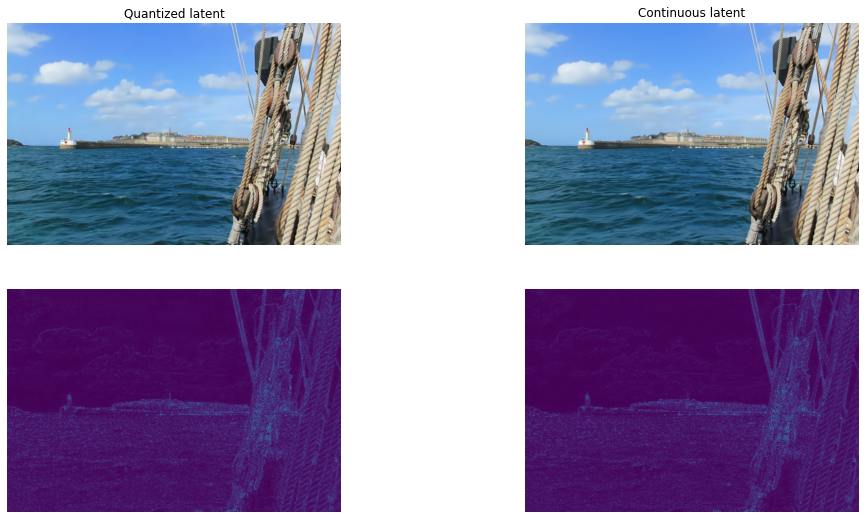

In [46]:
%matplotlib inline
fig, axes = plt.subplots(2, 2, figsize=(17, 9))
for ax in axes.ravel():
    ax.axis('off')
    
    axes[0][0].imshow(transforms.ToPILImage()(x_hat_y_hat.squeeze()))
    axes[0][0].title.set_text('Quantized latent')
    
    axes[1][0].imshow(torch.mean((x - x_hat_y_hat).abs(), axis=1).squeeze())
    
    axes[0][1].imshow(transforms.ToPILImage()(x_hat_y.squeeze()))
    axes[0][1].title.set_text('Continuous latent')
    
    axes[1][1].imshow(torch.mean((x - x_hat_y).abs(), axis=1).squeeze())

plt.show()